In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import vigra
from vigra import graphs
import copy
import os
import pylab
import time
from scipy.io import loadmat
import sys

import inferno
import multicutAuxFunctions as maf

In [2]:
resultsPath = 'results/test/'
resultImgsDirPH = resultsPath + 'partitionHamming'
resultImgsDirVOI = resultsPath + 'VOI'

# Training

In [3]:
trainSetPath = 'trainingSet/'
trainSetPath = 'fewImages/'


path = os.walk(trainSetPath)

trainingIds = []
trainingImgs = []

gtLabels = []
gtSols = []

trainingRags = []

superpixelDiameter = 20      # super-pixel size
slicWeight         = 25.0    # SLIC color - spatial weight
beta               = 0.5     # node vs edge weight
nodeNumStop        = 50      # desired num. nodes in result
minSize            = 15

############# load images and convert to LAB #############
for root, dirs, files in path:
    jpgFiles = [filename for filename in files if filename.endswith('.jpg')]
    T = len(jpgFiles)
    for i, filename in enumerate(jpgFiles):
        
        sys.stdout.write('\r')
        sys.stdout.write("[%-50s] %d%%" % ('='*int(float(i+1)/T*50), int(float(i+1)/T*100)))
        sys.stdout.flush()

        fileId = filename[:-4]
        trainingIds.append(fileId)
        
        img = vigra.impex.readImage(root + '/' + filename)
        trainingImgs.append(img)
        imgLab = vigra.colors.transform_RGB2Lab(img)
            
        gridGraph = graphs.gridGraph(img.shape[0:2])

        slicLabels = vigra.analysis.labelImage(vigra.analysis.slicSuperpixels(imgLab, slicWeight, superpixelDiameter, minSize=minSize)[0])
        rag = graphs.regionAdjacencyGraph(gridGraph, slicLabels)
        trainingRags.append(rag)
        
        gtWatershed = loadmat('trainingSet/groundTruth/' + fileId + '.mat')['groundTruth'][0,0][0][0][0]
        gtLabel = maf.getSuperpixelLabelList(rag, gtWatershed)
        gtLabels.append(gtLabel)
                
        gtSols.append(maf.getGroundTruthSol(rag, gtLabel))

        

[==================================================] 100%

In [5]:
trainingFeatureSpaces = []
trainingEdges = []
trainingFeatureSpacesPath = resultsPath + 'featureSpaces/training/'
if not os.path.exists(trainingFeatureSpacesPath):
    os.makedirs(trainingFeatureSpacesPath)

t1 = time.time()
T = len(trainingImgs)
print "Building up Feature Space..."
sys.stdout.flush()
for i, (rag, img, trainId) in enumerate(zip(trainingRags, trainingImgs, trainingIds)):
    trainingEdges.append(rag.uvIds().astype('uint64'))
    
    if (os.path.isfile(trainingFeatureSpacesPath + trainId + '.npy') == True):
        features = np.load(trainingFeatureSpacesPath + trainId + '.npy')
        if (os.path.isfile(trainingFeatureSpacesPath + 'featureNames.npy') == True):
            featureNames = np.load(trainingFeatureSpacesPath + 'featureNames.npy')
        
    else:
        features, featureNames = maf.getFeatures(rag, img, trainId)
        np.save(trainingFeatureSpacesPath + trainId + '.npy', features)
        np.save(trainingFeatureSpacesPath + 'featureNames.npy', featureNames)
        np.savetxt(resultsPath + 'featureNames.txt', featureNames, delimiter="\n", fmt="%s")
        
    
    sys.stdout.write('\r')
    sys.stdout.write("[%-50s] %d%%" % ('='*int(float(i+1)/T*50), int(float(i+1)/T*100)))
    sys.stdout.flush()
    
    trainingFeatureSpaces.append(features)
t2 = time.time()

print "\nTime to built up Feature Space:", t2-t1, "sec"

Building up Feature Space...
[==================================================] 100%
Time to built up Feature Space: 0.011440038681 sec


In [6]:
subGradParameter = dict(maxIterations=3, nThreads=4, n=1.)
weightVector = maf.performLearning(trainingFeatureSpaces, trainingRags, trainingEdges, gtLabels,
                                   loss='partitionHamming', learnerParameter=subGradParameter, regularizerStr=1.)

if not os.path.exists(resultImgsDirPH):
    os.makedirs(resultImgsDirPH)
np.save(resultImgsDirPH + 'weights.npy', weightVector)

f = pylab.figure(figsize=(16,10))
ax1 = f.add_subplot(111)
ax1.bar(range(auxWeightVec.shape[0]), auxWeightVec)
ax1.set_xticks(np.linspace(0.5, len(featureNames)-0.5, len(featureNames)))
ax1.set_xticklabels(featureNames, rotation=90, weight=550)

f.savefig(resultImgsDirPH + 'weights.png')

Begin weight learning...
Learning Duration:  0.0905508995056 sec


In [21]:
rfPath = resultsPath + 'RF.hdf5'
if (os.path.isfile(rfPath)):
    RF = vigra.learning.RandomForest(rfPath)
else:
    RF = maf.buildRandomForest(trainingFeatureSpaces, gtSols, rfPath)

In [22]:
trainingRfProbs = maf.getProbsFromRF(trainingFeatureSpaces, RF)

trainingFeatureSpaces[:] = [np.concatenate((featureSpace, prob), axis=1) for featureSpace, prob in zip(trainingFeatureSpaces, trainingRfProbs)]
featureNames.extend(('RF_Prob1', 'RF_Prob2'))


In [23]:
# extend weight vector for random forest features

auxWeightVec = np.zeros(len(weightVector))
for w in range(len(weightVector)):
    auxWeightVec[w] = weightVector[w]
    
weightVector = inferno.learning.WeightVector(len(weightVector)+2, 0.0)
for w in range(auxWeightVec.shape[0]):
    weightVector[w] = auxWeightVec[w]

In [27]:
StochGradParameter = dict(maxIterations=1, nPertubations=5, sigma=5., n=30.)
weightVector = maf.performLearning(trainingFeatureSpaces, trainingRags, trainingEdges, gtLabels,
                                   loss='variationOfInformation', learnerParameter=StochGradParameter, 
                                   regularizerStr=1., start=weightVector)

if not os.path.exists(resultImgsDirVOI):
    os.makedirs(resultImgsDirVOI)
np.save(resultImgsDirVOI + 'weights.npy', weightVector)


f = pylab.figure(figsize=(16,10))
ax1 = f.add_subplot(111)
ax1.bar(range(auxWeightVec.shape[0]), auxWeightVec)
ax1.set_xticks(np.linspace(0.5, len(featureNames)-0.5, len(featureNames)))
ax1.set_xticklabels(featureNames, rotation=90, weight=550)

f.savefig(resultImgsDirVOI + 'weights.png')

Begin weight learning...
Learning Duration:  269.030852079 sec


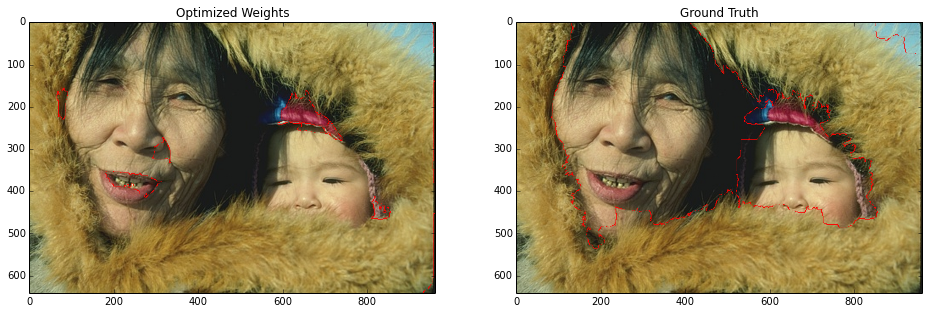

In [13]:
ParaMcModel = inferno.models.ParametrizedMulticutModel

nTrainSamples = len(trainingImgs)

modelVec = ParaMcModel.modelVector(nTrainSamples)

for n in range(nTrainSamples):

    nVar = trainingRags[n].nodeNum
    modelVec[n]._assign(nVar, trainingEdges[n]-1, trainingFeatureSpaces[n], weightVector) # -1 at edges so that nodes start at 0


############ Use Multicut on training image with given weightVector ###############
i = 0

if (i >= nTrainSamples or i < 0):
    print "i invalid! i was set to 0 for now!"
    i = 0

solver = inferno.inference.multicut(modelVec[i])

visitor = inferno.inference.verboseVisitor(modelVec[i])
#visitor = inferno.inference.visitor(modelVec[i])

solver.infer(visitor.visitor())    # bei .infer() gibt er was in konsole aus


conf = solver.conf()

arg = conf.view().astype('uint32')
arg = np.array([0] + list(arg), dtype=np.uint32) + 1

f = pylab.figure(figsize=(16,16))
ax0 = f.add_subplot(1,2,1)
trainingRags[i].show(trainingImgs[i], labels=arg, edgeColor=(1,0,0), alpha=0.)
ax0.set_title('Optimized Weights')

ax1 = f.add_subplot(1,2,2)
trainingRags[i].show(trainingImgs[i], labels=gtLabels[i], edgeColor=(1,0,0), alpha=0.)
ax1.set_title('Ground Truth')


pylab.show()

73
(1113, 75)


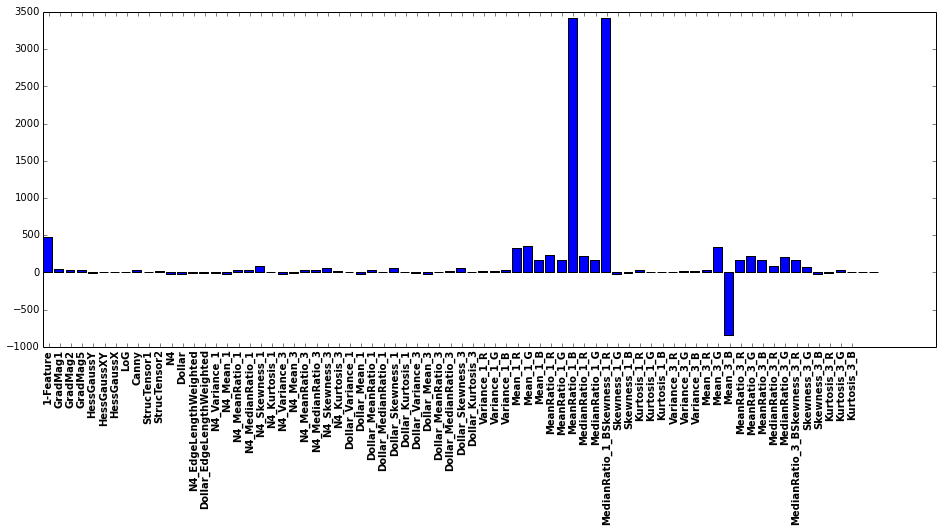

array([  4.76217949e+02,   4.44797991e+01,   3.80638274e+01,
         2.92915988e+01,  -3.07020116e+00,  -1.26046998e+00,
        -1.43949479e+00,  -2.91187541e-01,   3.45568599e+01,
         1.12683952e+01,   1.94330795e+01,  -1.81636145e+01,
        -2.05018124e+01,  -7.31590167e+00,  -9.03810945e+00,
        -2.15710132e+00,  -1.81636145e+01,   3.72766939e+01,
         3.75007865e+01,   8.05999341e+01,   5.93050178e+00,
        -1.55258173e+01,  -1.44723091e+01,   2.56037570e+01,
         2.55822774e+01,   6.33964026e+01,   1.27878668e+01,
         9.32682903e+00,  -2.05018124e+01,   2.50157703e+01,
         1.04982911e+01,   6.47932603e+01,   7.86559371e-01,
        -2.27840286e+00,  -1.63629429e+01,   1.11564524e+01,
         1.38478958e+01,   5.43674950e+01,   9.85180710e+00,
         1.59758509e+01,   1.76898153e+01,   2.73298390e+01,
         3.34003611e+02,   3.57451021e+02,   1.59490635e+02,
         2.29235700e+02,   1.68114934e+02,   3.42417189e+03,
         2.13551290e+02,

In [9]:
print len(featureNames)
print trainingFeatureSpaces[0].shape

auxWeightVec = np.zeros(len(weightVector))
for w in range(len(weightVector)):
    auxWeightVec[w] = weightVector[w]

f = plt.figure(figsize=(16,6))
ax = f.add_subplot(111)

ax.bar(range(auxWeightVec.shape[0]), auxWeightVec)
ax.set_xticks(np.linspace(0.5, len(featureNames)-0.5, len(featureNames)))
ax.set_xticklabels(featureNames, rotation=90, weight=550)
plt.show()


# Testing

In [7]:
########### Work with learned Random Forest and weights on Test Set #################

testSetPath = 'testSet/'
testSetPath = 'fewImages/'

path = os.walk(testSetPath)

testImgs = []
testIds = []

testRags = []


superpixelDiameter = 20       # super-pixel size
slicWeight         = 25.0     # SLIC color - spatial weight
beta               = 0.5     # node vs edge weight
nodeNumStop        = 50         # desired num. nodes in result
minSize            = 15


############# load images and convert to LAB #############
T = len(os.listdir(testSetPath))
for root, dirs, files in path:
    for i, filename in enumerate(files):
        if (filename.endswith('.jpg')):
            
            sys.stdout.write('\r')
            sys.stdout.write("[%-50s] %d%%" % ('='*int(float(i+1)/T*50), int(float(i+1)/T*100)))
            sys.stdout.flush()

            fileId = filename[:-4]
            testIds.append(fileId)
            img = vigra.impex.readImage(root + filename)
            imgLab = vigra.colors.transform_RGB2Lab(img)
            testImgs.append(img)

            gridGraph = graphs.gridGraph(img.shape[0:2])

            slicLabels = vigra.analysis.labelImage(vigra.analysis.slicSuperpixels(imgLab, slicWeight, superpixelDiameter, minSize=minSize)[0])
            rag = graphs.regionAdjacencyGraph(gridGraph, slicLabels)
            testRags.append(rag)
            
            


[==================================================] 100%

In [8]:
testFeatureSpaces = []
testEdges = []

testingFeatureSpacesPath = resultsPath + 'featureSpaces/testing/'
if not os.path.exists(testingFeatureSpacesPath):
    os.makedirs(testingFeatureSpacesPath)

print "Building up Feature Space..."
T = len(testImgs)
for i, (rag, img, testId) in enumerate(zip(testRags, testImgs, testIds)):
    testEdges.append(rag.uvIds().astype('uint64'))
    
    if (os.path.isfile(testingFeatureSpacesPath + testId + '.npy') == True):
        features = np.load(testingFeatureSpacesPath + testId + '.npy')
        
    else:
        features = maf.getFeatures(rag, img, testId)[0]
        np.save(testingFeatureSpacesPath + testId + '.npy', features)

    sys.stdout.write('\r')
    sys.stdout.write("[%-50s] %d%%" % ('='*int(float(i+1)/T*50), int(float(i+1)/T*100)))
    sys.stdout.flush()

    testFeatureSpaces.append(features)

Building up Feature Space...
[==================================================] 100%

In [40]:
probs = maf.getProbsFromRF(testFeatureSpaces, RF)

testFeatureSpaces[:] = [np.concatenate((featureSpace, prob), axis=1) for featureSpace, prob in zip(testFeatureSpaces, probs)]

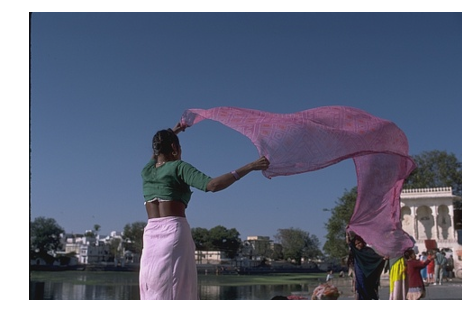

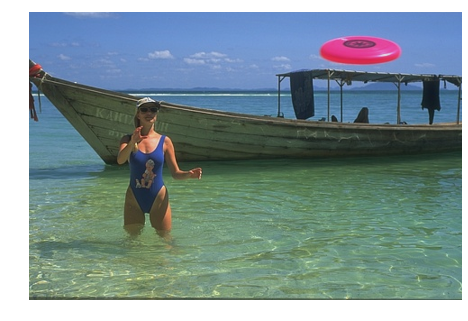

In [9]:
maf.performTesting(testImgs, testRags, testEdges, testFeatureSpaces, testIds, weightVector, resultImgsDir)

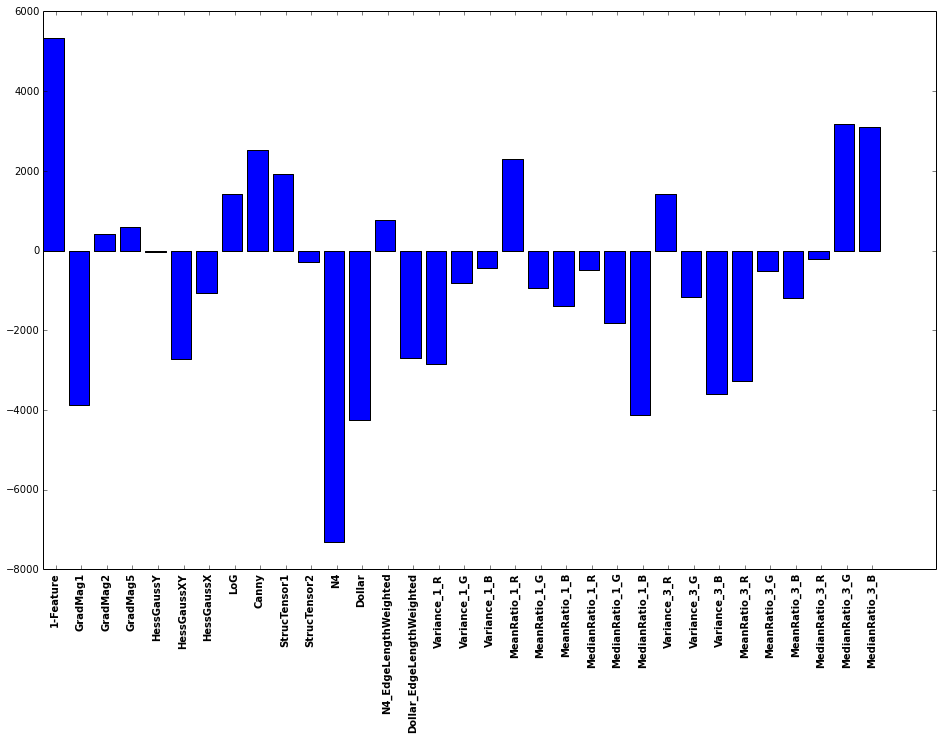

In [30]:
f = pylab.figure(figsize=(16,10))
ax1 = f.add_subplot(111)
ax1.bar(range(auxWeightVec.shape[0]), auxWeightVec)
ax1.set_xticks(np.linspace(0.5, len(featureNames)-0.5, len(featureNames)))
ax1.set_xticklabels(featureNames, rotation=90, weight=550)

f.savefig('results/variationOfInformation/151112_hammingStart/weights.png')

In [43]:
a = np.array(['a', 'b'])

np.where(a=='a')

(array([0]),)

1

In [3]:
rag = trainingRags[0]
img = trainingImgs[0]


#a = maf.getEdgeWeightsFromNodesAround2(rag, img, 1, variance=True, meanRatio=True, medianRatio=True)
b = maf.getEdgeWeightsFromNodesAround3(rag, img, 1, variance=True, mean=True, meanRatio=True, medianRatio=True, 
                                                    skewness=True, kurtosis=True)




In [4]:
import inferno

weightConstraints = inferno.learning.WeightConstraints(3)

weightConstraints.addBound(0, 0.9, 1.1)

In [1]:
import numpy as np

In [39]:
print trainingFeatureSpaces[1].shape
print testFeatureSpaces[0].shape

(1089, 77)
(1778, 75)


In [23]:
np.save(resultsPath + 'w.npy', weightVector)
w = np.load(resultsPath + 'w.npy')

w.shape

(75,)

In [31]:
np.savetxt(resultsPath + 'featureNames.txt', featureNames, delimiter="\n", fmt="%s")

In [6]:
if not os.path.exists('blubb/bla/'):
    os.makedirs('blubb/bla/')